### 3.1 Evaluation Criterion

#### AIC (akaike information criterion)

$ AIC = -2ln(L) + 2k$

#### BIC (bayesian information criterion)

$ BIC = -2ln(L) + ln(n)*k$

### 3.2 Mathematical formulation of ARIMA models

[AR, MA and ARMA models](http://www.math.unm.edu/~ghuerta/tseries/week4_1.pdf)

[The Identification of ARIMA Models](https://www.le.ac.uk/users/dsgp1/COURSES/THIRDMET/MYLECTURES/4XIDNTIFY.pdf)

[Interpreting the plots](http://www.dipecodir.it/upload/L072014(1).pdf)

### 3.3 Box-Jenkins Approach to Non-Seasonal ARIMA Modeling

- Model diagnostic checking
- Re-specification of the model if one or more of the underlying statistical assumptions is not satisfied
- Model selection
- Perform statistical inference and/or forecasting
- Forecast evaluation

In [21]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings; warnings.simplefilter('ignore')

from __future__ import absolute_import, division, print_function

import sys
import os

import pandas as pd
import numpy as np

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Import the csv file containing the series for the analysis
# This is the file we just analyzed in Exercise 2

filename_ts = 'data/series1.csv'
ts_df = pd.read_csv(filename_ts, index_col=0, parse_dates=[0])

n_sample = ts_df.shape[0]

In [3]:
print(ts_df.shape)
print(ts_df.head())

(120, 1)
              value
2006-06-01  0.21507
2006-07-01  1.14225
2006-08-01  0.08077
2006-09-01 -0.73952
2006-10-01  0.53552


### Create a training sample and testing sample before analying the series

In [6]:
n_train = int(0.95*n_sample)+1
n_forecast = n_sample - n_train

ts_train = ts_df.iloc[:n_train]['value']
ts_test = ts_df.iloc[n_train:]['value']

In [7]:
print(ts_train.shape)
print(ts_test.shape)

(115,)
(5,)


In [8]:
print("Training Series:", "\n", ts_train.tail(),"\n")
print("Testing Series:", "\n", ts_test.head())

Training Series: 
 2015-08-01    0.60371
2015-09-01   -1.27372
2015-10-01   -0.93284
2015-11-01    0.08552
2015-12-01    1.20534
Name: value, dtype: float64 

Testing Series: 
 2016-01-01    2.16411
2016-02-01    0.95226
2016-03-01    0.36485
2016-04-01   -2.26487
2016-05-01   -2.38168
Name: value, dtype: float64


In [4]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

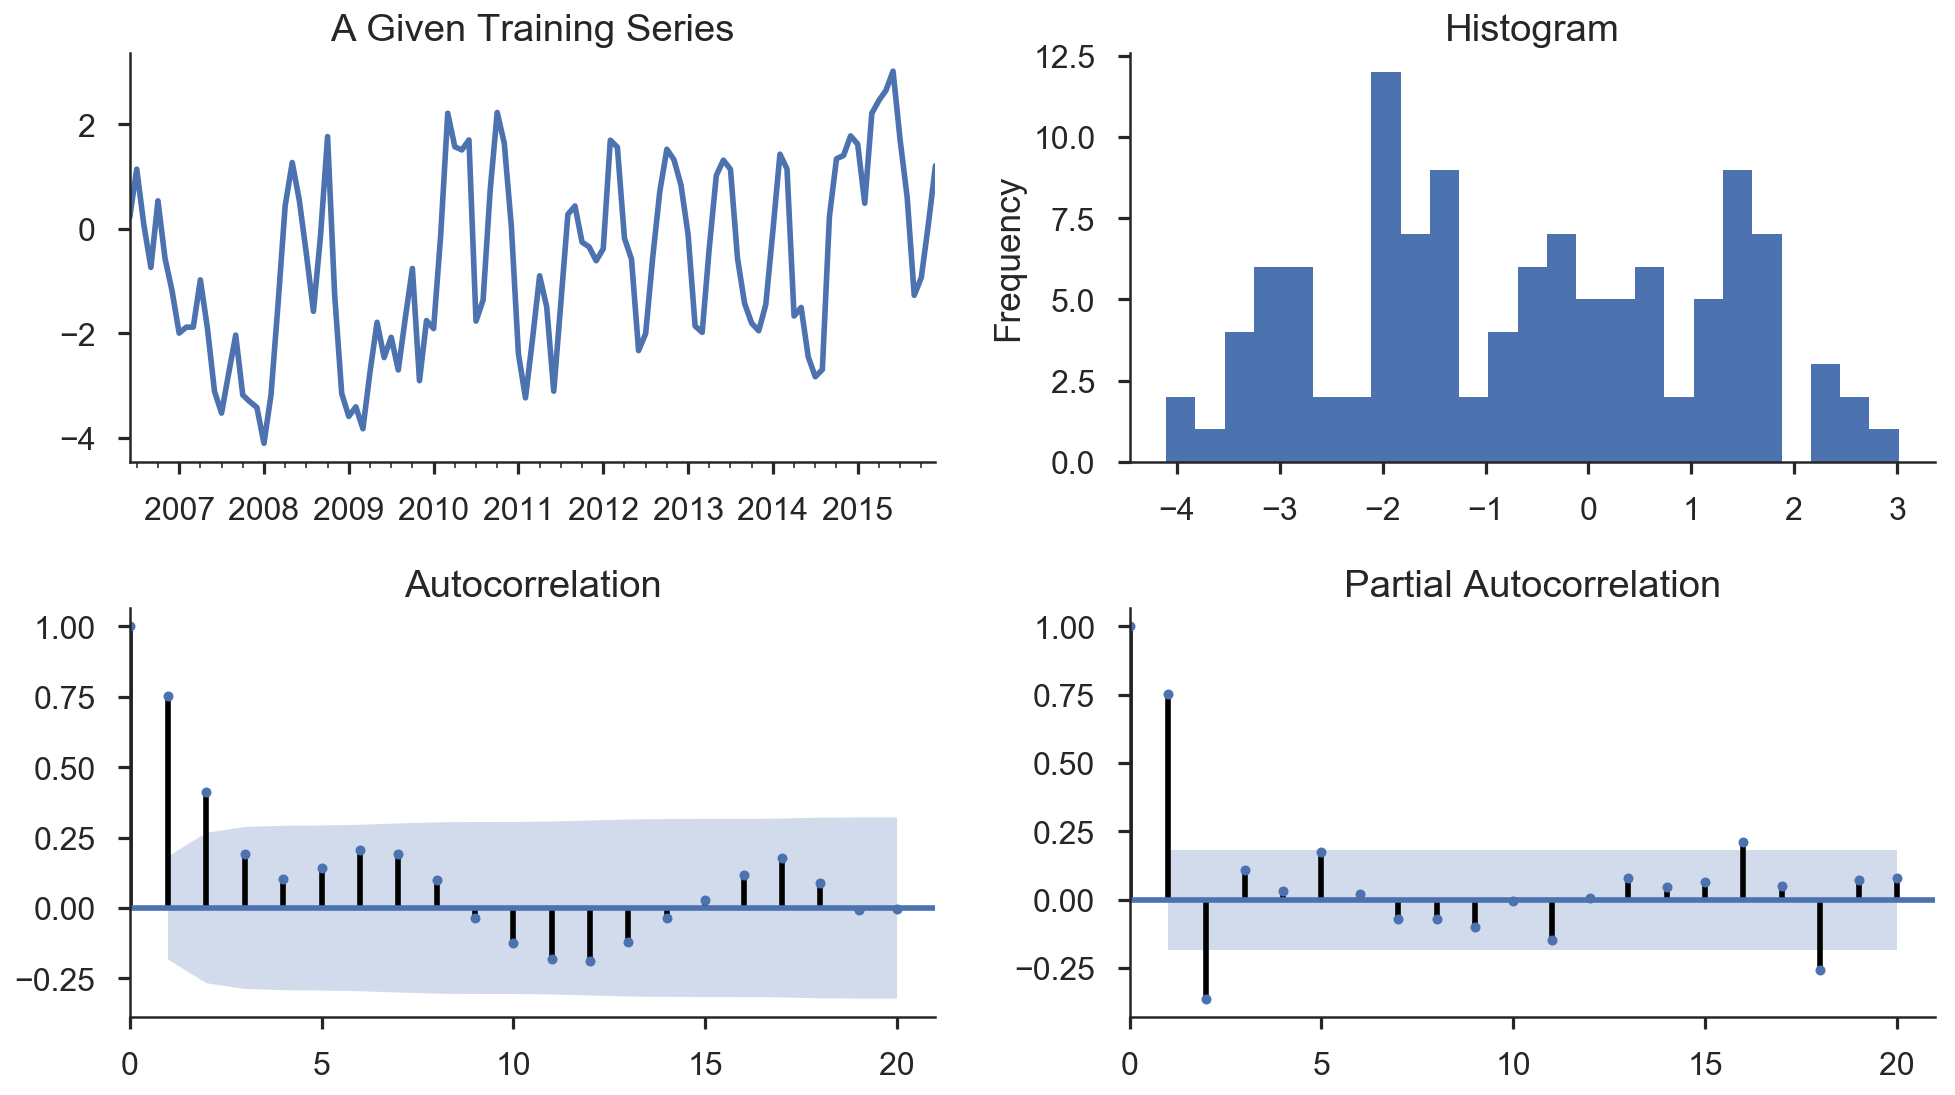

In [9]:
tsplot(ts_train, title='A Given Training Series', lags=20);

In [10]:
arima200 = sm.tsa.SARIMAX(ts_train, order=(2,0,0))
model_results = arima200.fit()
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  value   No. Observations:                  115
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -171.685
Date:                Tue, 07 Nov 2017   AIC                            349.370
Time:                        11:49:08   BIC                            357.605
Sample:                    06-01-2006   HQIC                           352.712
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0609      0.101     10.511      0.000       0.863       1.259
ar.L2         -0.3456      0.094     -3.664      0.000      -0.530      -0.161
sigma2         1.1471      0.153      7.516      0.000       0.848       1.446
===================================================================================
Ljung-Box (Q):                       70.87   Jarque-Bera (JB):                 1.39
Prob(Q):                              0.00   Prob(JB):                         0.50
Heteroskedasticity (H):               0.76   Skew:                            -0.27
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Search over a few models using the visual clues above as a strating point

In [23]:
import itertools

p_min = 0
d_min = 0
q_min = 0
p_max = 4
d_max = 0
q_max = 4

# Initialize a DataFrame to store the results
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
    
    try:
        model = sm.tsa.SARIMAX(ts_train, order=(p, d, q),
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)

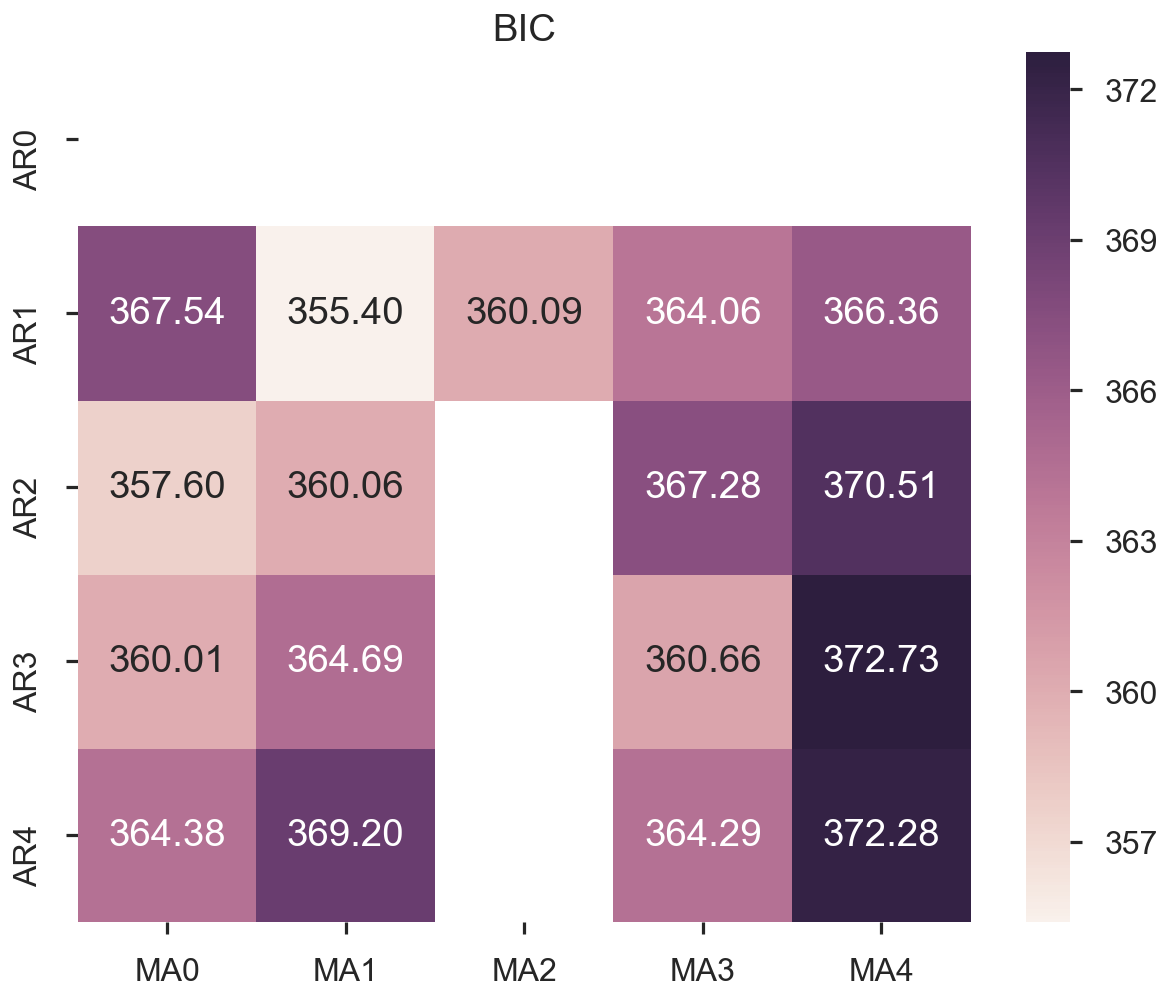

In [19]:
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(results_bic, 
                 mask = results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f')
ax.set_title('BIC')

#### Alternative model selection method, limited to only searching AR and MA parameters

In [22]:
train_results = sm.tsa.arma_order_select_ic(ts_train, ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=4)

print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)

AIC (4, 2)
BIC (1, 1)


### 3.4 Model Diagnostic Checking

The residuals from a model are calculated as the difference between the actual values and the fitted values: $ e_i = y_i - \hat{y_i}$. Each residual is the unpredictable component of the associated observation.

When the data are a time series, you should look at an ACF plot of the residuals. This will reveal if there is any autocorrelation in the residuals (suggesting that there is information that has not been accounted for in the model).

**Outliers** suggest there was something unusual happening. It would be worth investigating that outlier to see if there were any unusual circumstances or events.

Histogram: it is a good idea to check if the residuals are normally distributed. As explained earlier, this is not essential for forecasting, but it does make the calculation of prediction intervals much easier.

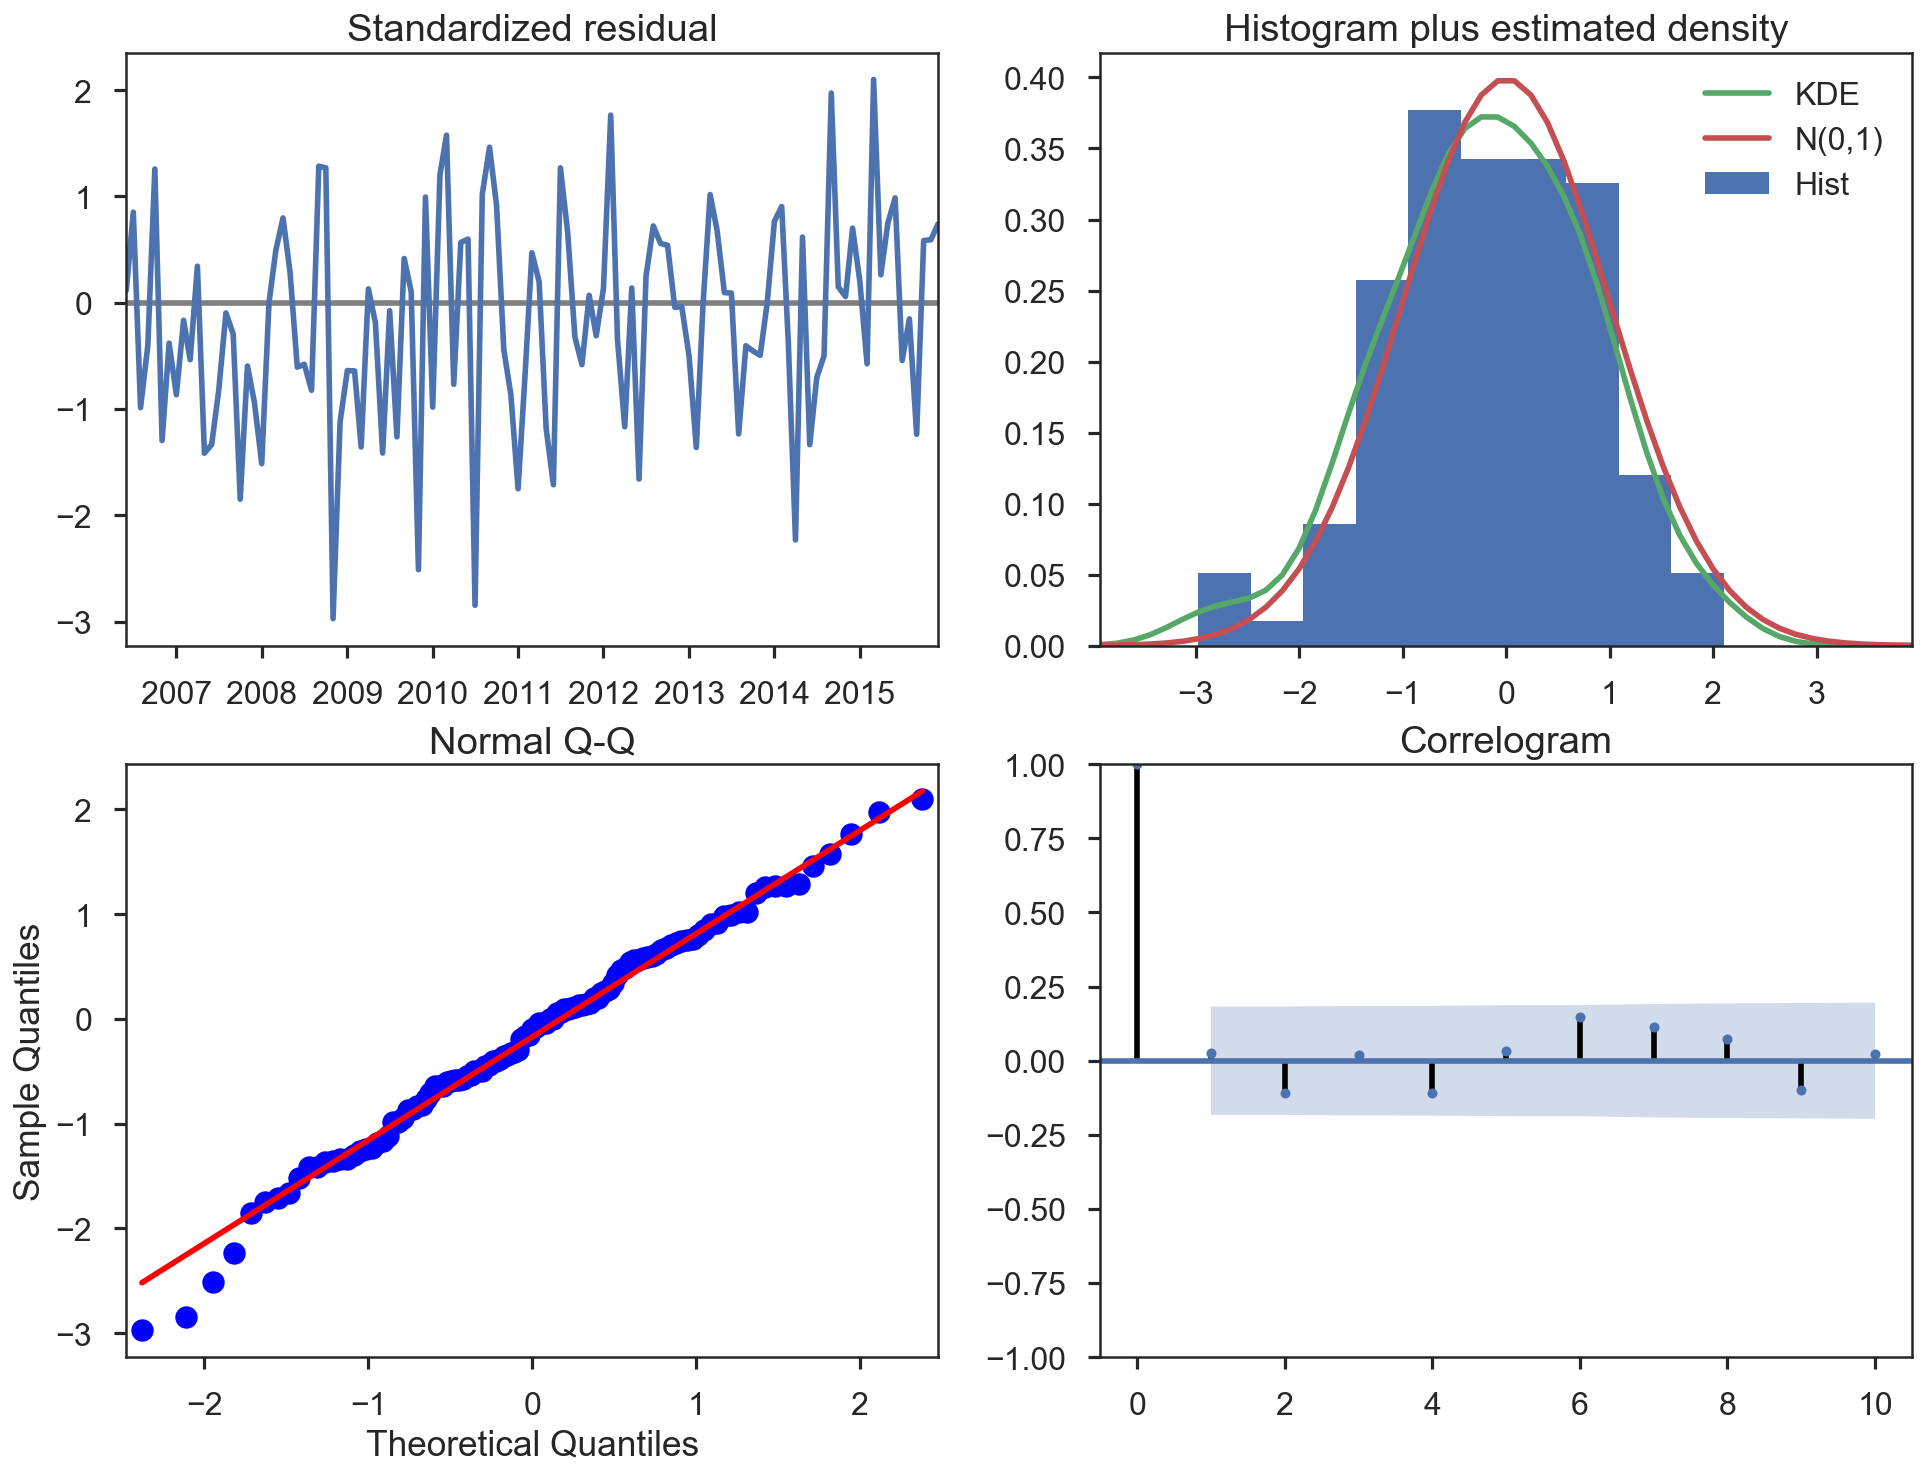

In [26]:
model_results.plot_diagnostics(figsize=(16, 12));

### 3.5 Formal testing

In [27]:
# Re-run the above statistical tests, and more. To be used when selecting viable models.

het_method='breakvar'
norm_method='jarquebera'
sercor_method='ljungbox'

(het_stat, het_p) = model_results.test_heteroskedasticity(het_method)[0]
norm_stat, norm_p, skew, kurtosis = model_results.test_normality(norm_method)[0]
sercor_stat, sercor_p = model_results.test_serial_correlation(method=sercor_method)[0]
sercor_stat = sercor_stat[-1] # last number for the largest lag
sercor_p = sercor_p[-1] # last number for the largest lag

# Run Durbin-Watson test on the standardized residuals.
# The statistic is approximately equal to 2*(1-r), where r is the sample autocorrelation of the residuals.
# Thus, for r == 0, indicating no serial correlation, the test statistic equals 2.
# This statistic will always be between 0 and 4. The closer to 0 the statistic,
# the more evidence for positive serial correlation. The closer to 4,
# the more evidence for negative serial correlation.
# Essentially, below 1 or above 3 is bad.
dw = sm.stats.stattools.durbin_watson(model_results.filter_results.standardized_forecasts_error[0, model_results.loglikelihood_burn:])

# check whether roots are outside the unit circle (we want them to be);
# will be True when AR is not used (i.e., AR order = 0)
arroots_outside_unit_circle = np.all(np.abs(model_results.arroots) > 1)
# will be True when MA is not used (i.e., MA order = 0)
maroots_outside_unit_circle = np.all(np.abs(model_results.maroots) > 1)

print('Test heteroskedasticity of residuals ({}): stat={:.3f}, p={:.3f}'.format(het_method, het_stat, het_p));
print('\nTest normality of residuals ({}): stat={:.3f}, p={:.3f}'.format(norm_method, norm_stat, norm_p));
print('\nTest serial correlation of residuals ({}): stat={:.3f}, p={:.3f}'.format(sercor_method, sercor_stat, sercor_p));
print('\nDurbin-Watson test on residuals: d={:.2f}\n\t(NB: 2 means no serial correlation, 0=pos, 4=neg)'.format(dw))
print('\nTest for all AR roots outside unit circle (>1): {}'.format(arroots_outside_unit_circle))
print('\nTest for all MA roots outside unit circle (>1): {}'.format(maroots_outside_unit_circle))


Test heteroskedasticity of residuals (breakvar): stat=0.758, p=0.397

Test normality of residuals (jarquebera): stat=1.394, p=0.498

Test serial correlation of residuals (ljungbox): stat=70.871, p=0.002

Durbin-Watson test on residuals: d=1.88
	(NB: 2 means no serial correlation, 0=pos, 4=neg)

Test for all AR roots outside unit circle (>1): True

Test for all MA roots outside unit circle (>1): True


### 3.6 Model Performance Evaluation (in-sample fit) 

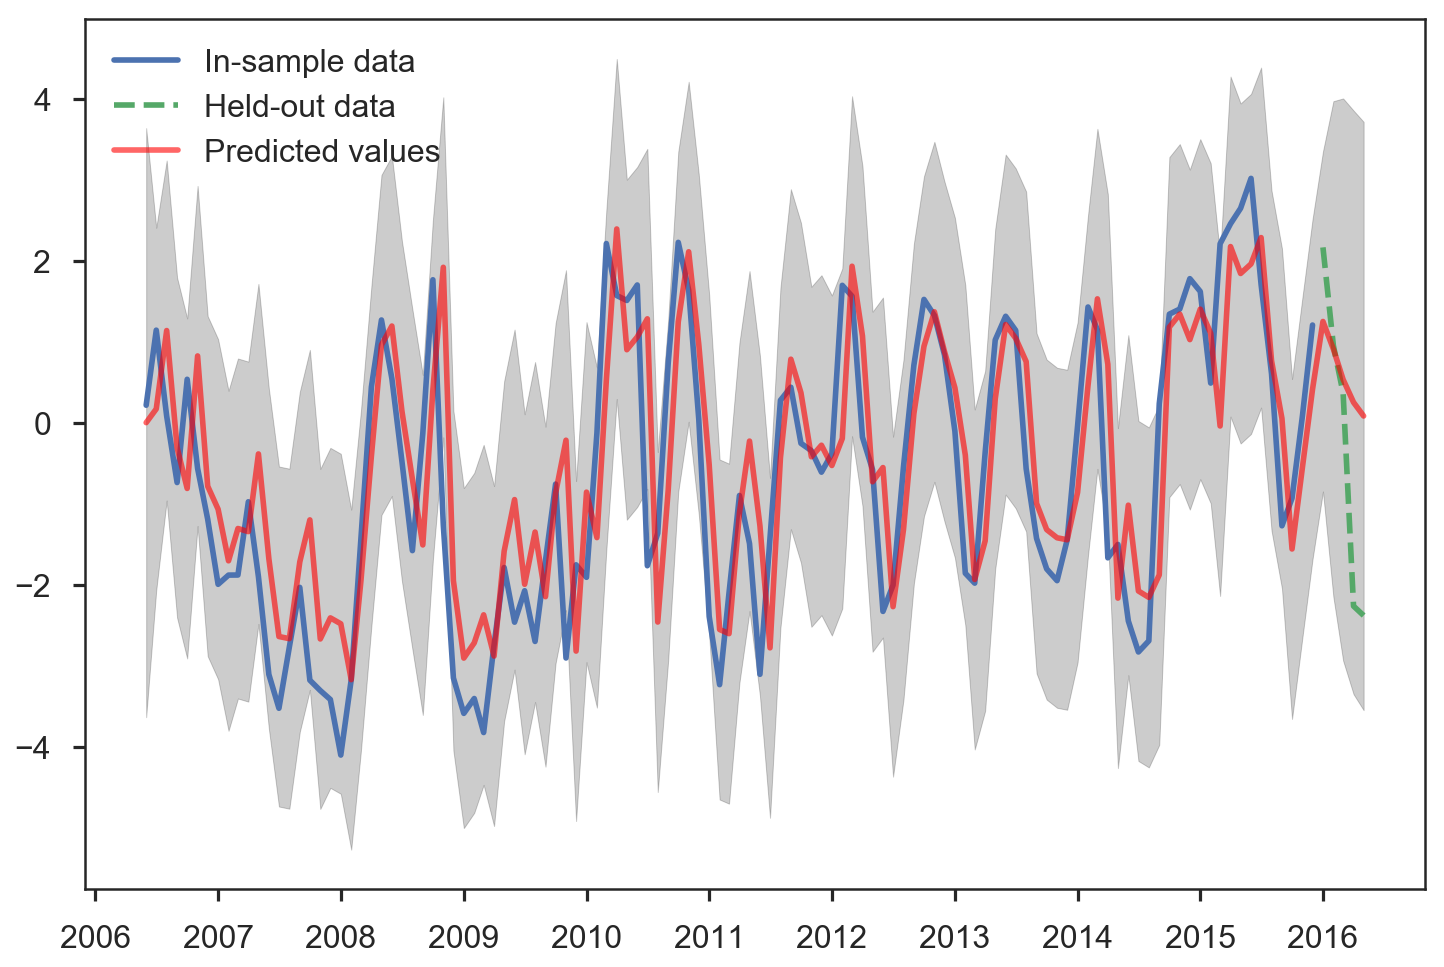

In [28]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(ts_train, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(ts_test, label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = ts_train.index[model_results.loglikelihood_burn]
pred_end = ts_test.index[-1]
pred = model_results.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                    end=pred_end.strftime('%Y-%m-%d'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax1.legend(loc='best');

In [29]:
def get_rmse(y, y_hat):
    '''Root Mean Square Error
    https://en.wikipedia.org/wiki/Root-mean-square_deviation
    '''
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

def get_mape(y, y_hat):
    '''Mean Absolute Percent Error
    https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    '''
    perc_err = (100*(y - y_hat))/y
    return np.mean(abs(perc_err))

def get_mase(y, y_hat):
    '''Mean Absolute Scaled Error
    https://en.wikipedia.org/wiki/Mean_absolute_scaled_error
    '''
    abs_err = abs(y - y_hat)
    dsum=sum(abs(y[1:] - y_hat[1:]))
    t = len(y)
    denom = (1/(t - 1))* dsum
    return np.mean(abs_err/denom)

In [30]:
rmse = get_rmse(ts_train, pred_mean.ix[ts_train.index])
print("RMSE: ", rmse)

mape = get_mape(ts_train, pred_mean.ix[ts_train.index])
print("MAPE: ", mape)

mase = get_mase(ts_train, pred_mean.ix[ts_train.index])
print("MASE: ", mase)

RMSE:  1.07163687884
MAPE:  149.4030258275067
MASE:  0.99348789343955


### 3.7 Forecasting and Forecast Evaluation

In [31]:
rmse = get_rmse(ts_test, pred_mean.ix[ts_test.index])
print(rmse)

mape = get_mape(ts_test, pred_mean.ix[ts_test.index])
print(mape)

mase = get_mase(ts_test, pred_mean.ix[ts_test.index])
print(mase)

1.62882399523
61.456250126142166
0.9410128986179537


### 3.8 Case Study

In [32]:
# Import the csv file containing the series for the analysis

# Step 1a: Read the data series
filename_ts = 'data/series2.csv'
series2_df = pd.read_csv(filename_ts, index_col=0, parse_dates=[0])

# Step 1b: Create the training and testing series before analyzing the series

n_sample = series2_df.shape[0]

n_train=int(0.95*n_sample)+1
n_forecast=n_sample-n_train

series2_train = series2_df.iloc[:n_train]['value']
series2_test  = series2_df.iloc[n_train:]['value']
print(series2_train.shape)
print(series2_test.shape)
print("Training Series:", "\n", series2_train.tail(), "\n")
print("Testing Series:", "\n", series2_test.head())

(238,)
(12,)
Training Series: 
 2017-11-01    1.08165
2017-12-01    0.40939
2018-01-01    2.17708
2018-02-01    2.21133
2018-03-01   -0.39728
Name: value, dtype: float64 

Testing Series: 
 2018-04-01    0.82064
2018-05-01    0.66053
2018-06-01    0.78946
2018-07-01   -0.02444
2018-08-01   -0.39888
Name: value, dtype: float64


In [33]:
# Step 2a: Examine the basic structure of the data
print("Data shape:", series2_train.shape, "\n")
print("First 5 observations of the data series:", "\n", series2_train.head(), "\n")
print("Last 5 observations of the data series:", "\n", series2_train.tail())

Data shape: (238,) 

First 5 observations of the data series: 
 1998-06-01   -0.59883
1998-07-01   -0.80018
1998-08-01    2.29898
1998-09-01    1.15039
1998-10-01   -1.19258
Name: value, dtype: float64 

Last 5 observations of the data series: 
 2017-11-01    1.08165
2017-12-01    0.40939
2018-01-01    2.17708
2018-02-01    2.21133
2018-03-01   -0.39728
Name: value, dtype: float64


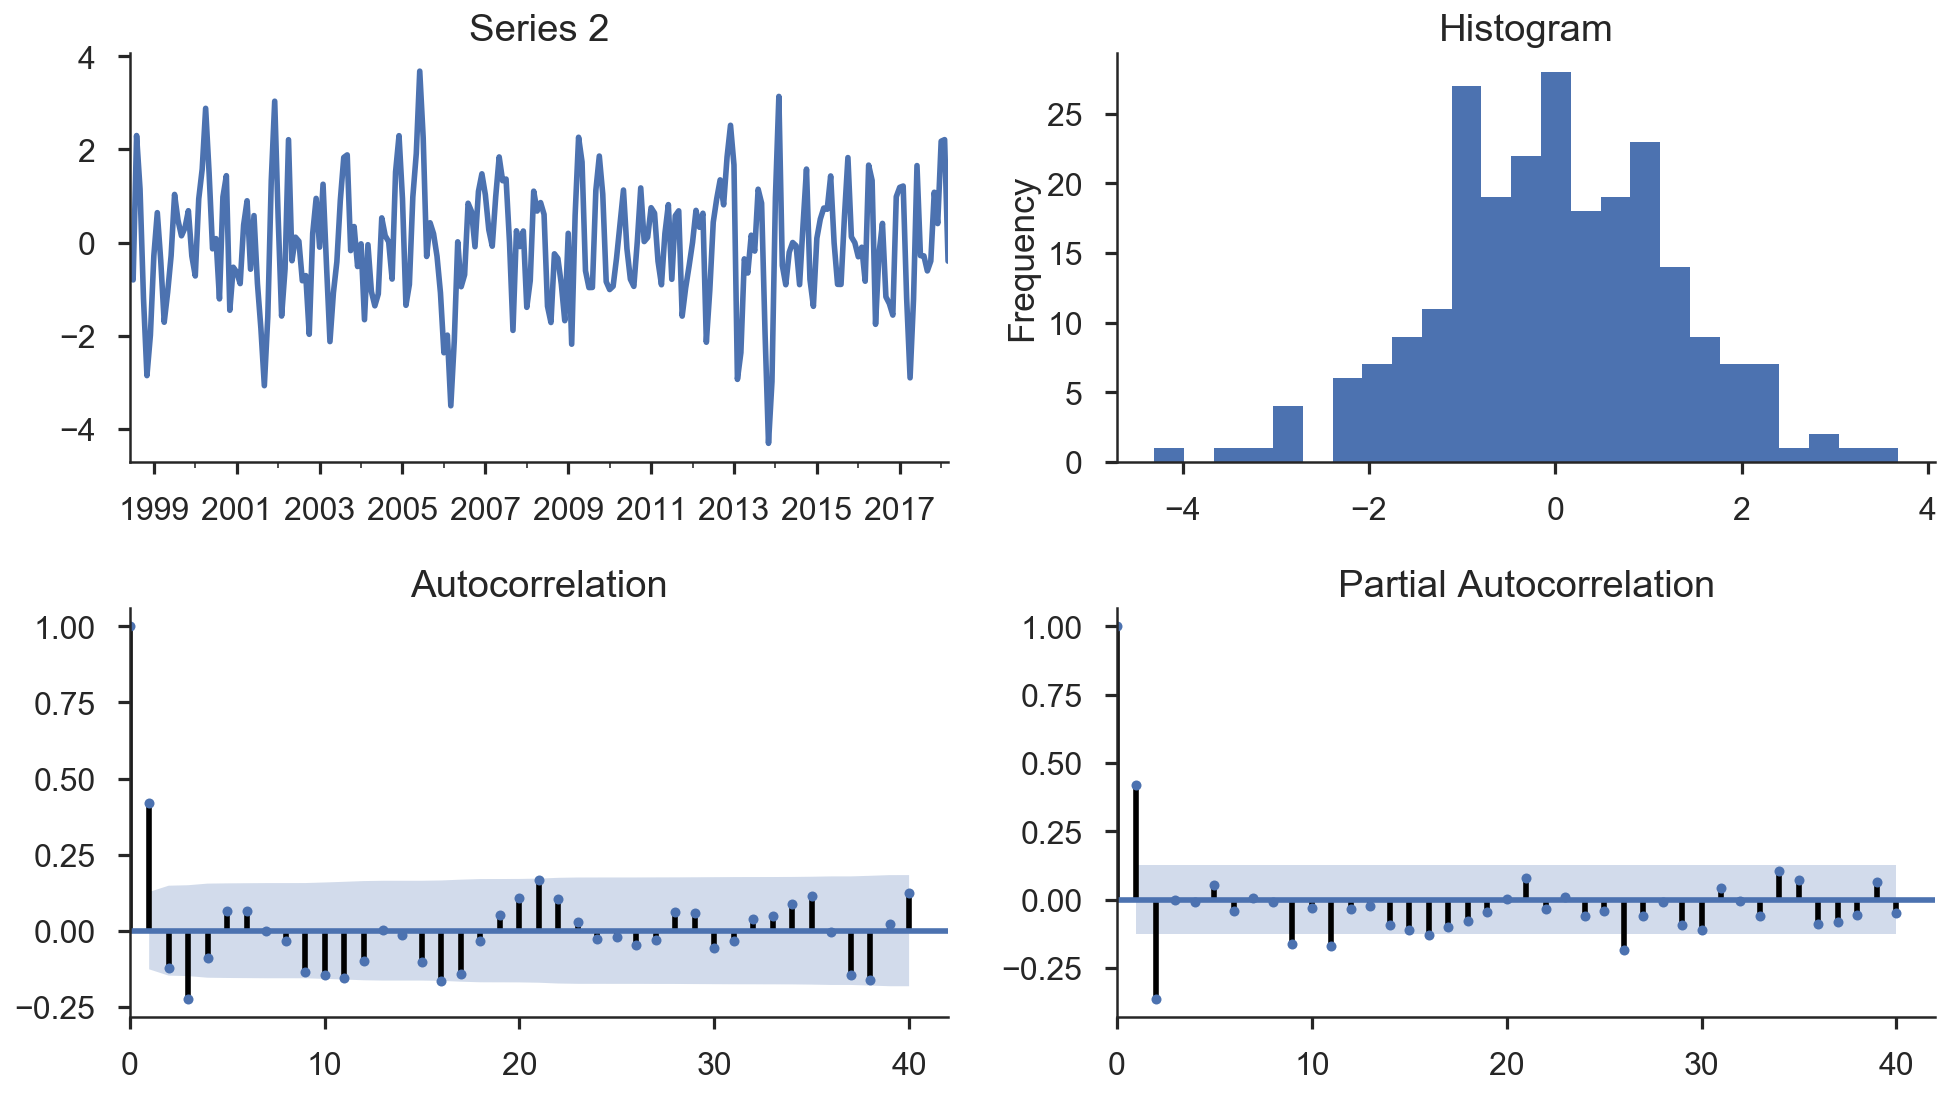

In [35]:
# Step 2b: Examine the series and use the visuals as clues for the choice of the orders of the ARIMA model
# Choose the number of lags you would like to display. Pick a number that is at least 20.

# tsplot(series2_train, title='Series 2', lags=?);

tsplot(series2_train, title='Series 2', lags=40);

In [48]:
# Step 2c: Conduct any necessary transformations (such as natural log, difference, difference in natural log, etc )
# and repeat Step 2b


# Step 3: Estimate an non-Seasonal ARIMA model
# Note: you will have to pick the orders (p,d,q)

# ex3_mod = sm.tsa.statespace.SARIMAX(series2_train, order=(?,?,?))
ex3_mod = sm.tsa.statespace.SARIMAX(series2_train, order=(3,0,0))
ex3_arima_fit = ex3_mod.fit()
print(ex3_arima_fit.summary())

# Discuss your results

                           Statespace Model Results                           
Dep. Variable:                  value   No. Observations:                  238
Model:               SARIMAX(3, 0, 0)   Log Likelihood                -356.060
Date:                Tue, 07 Nov 2017   AIC                            720.120
Time:                        14:50:36   BIC                            734.009
Sample:                    06-01-1998   HQIC                           725.718
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5721      0.065      8.797      0.000       0.445       0.700
ar.L2         -0.3638      0.076     -4.785      0.000      -0.513      -0.215
ar.L3         -0.0047      0.070     -0.067      0.9

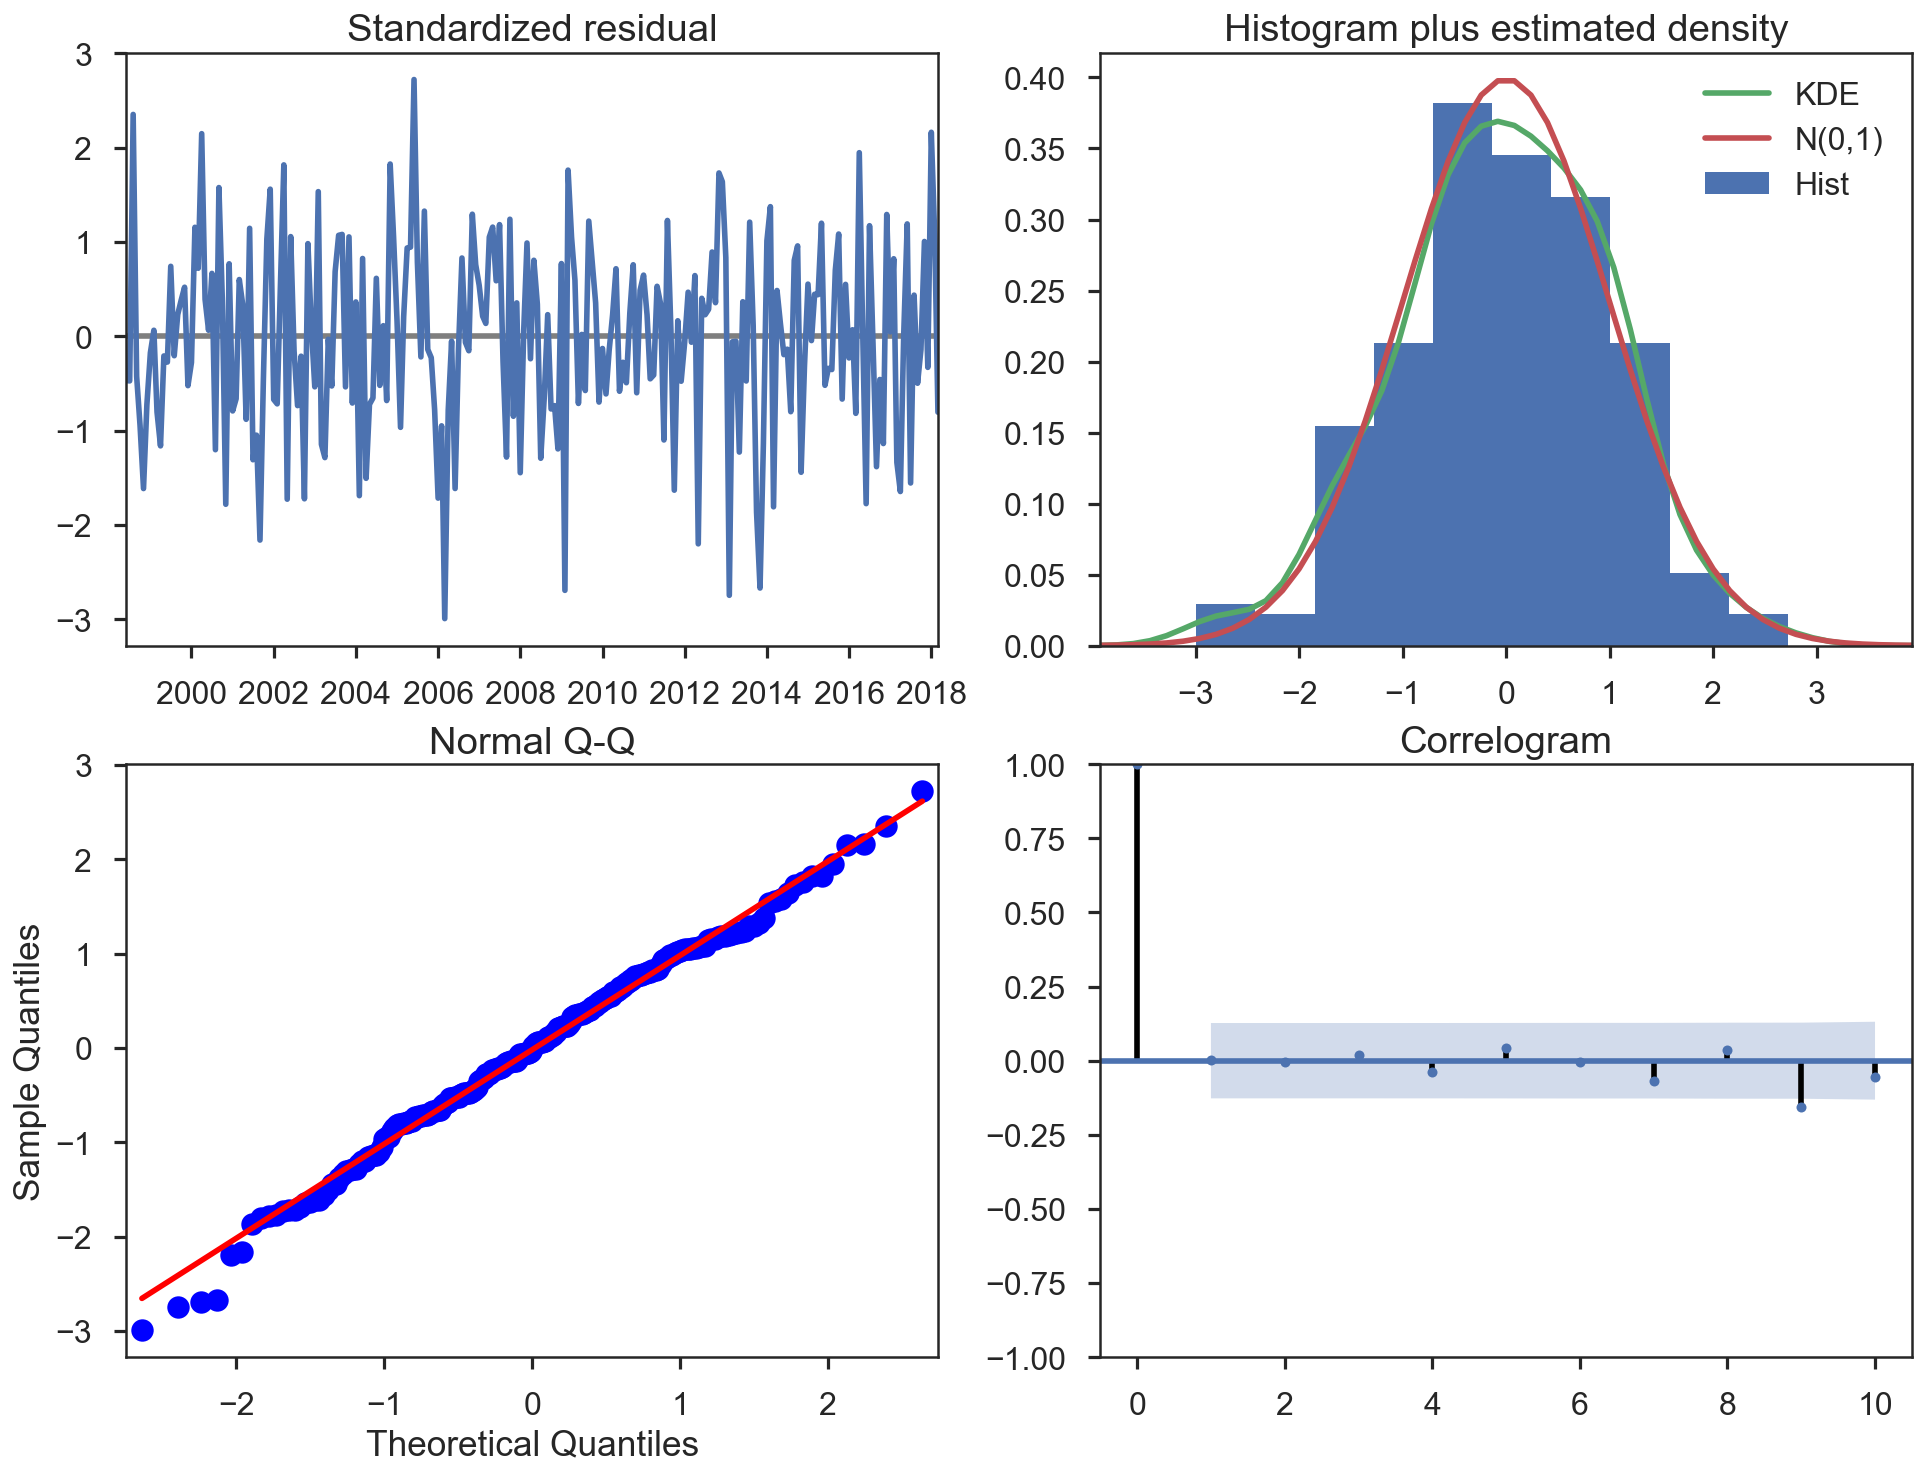

In [49]:
# Step 4: Conduct model diagnostic check

ex3_arima_fit.plot_diagnostics(figsize=(16, 12));

# Discuss these plots

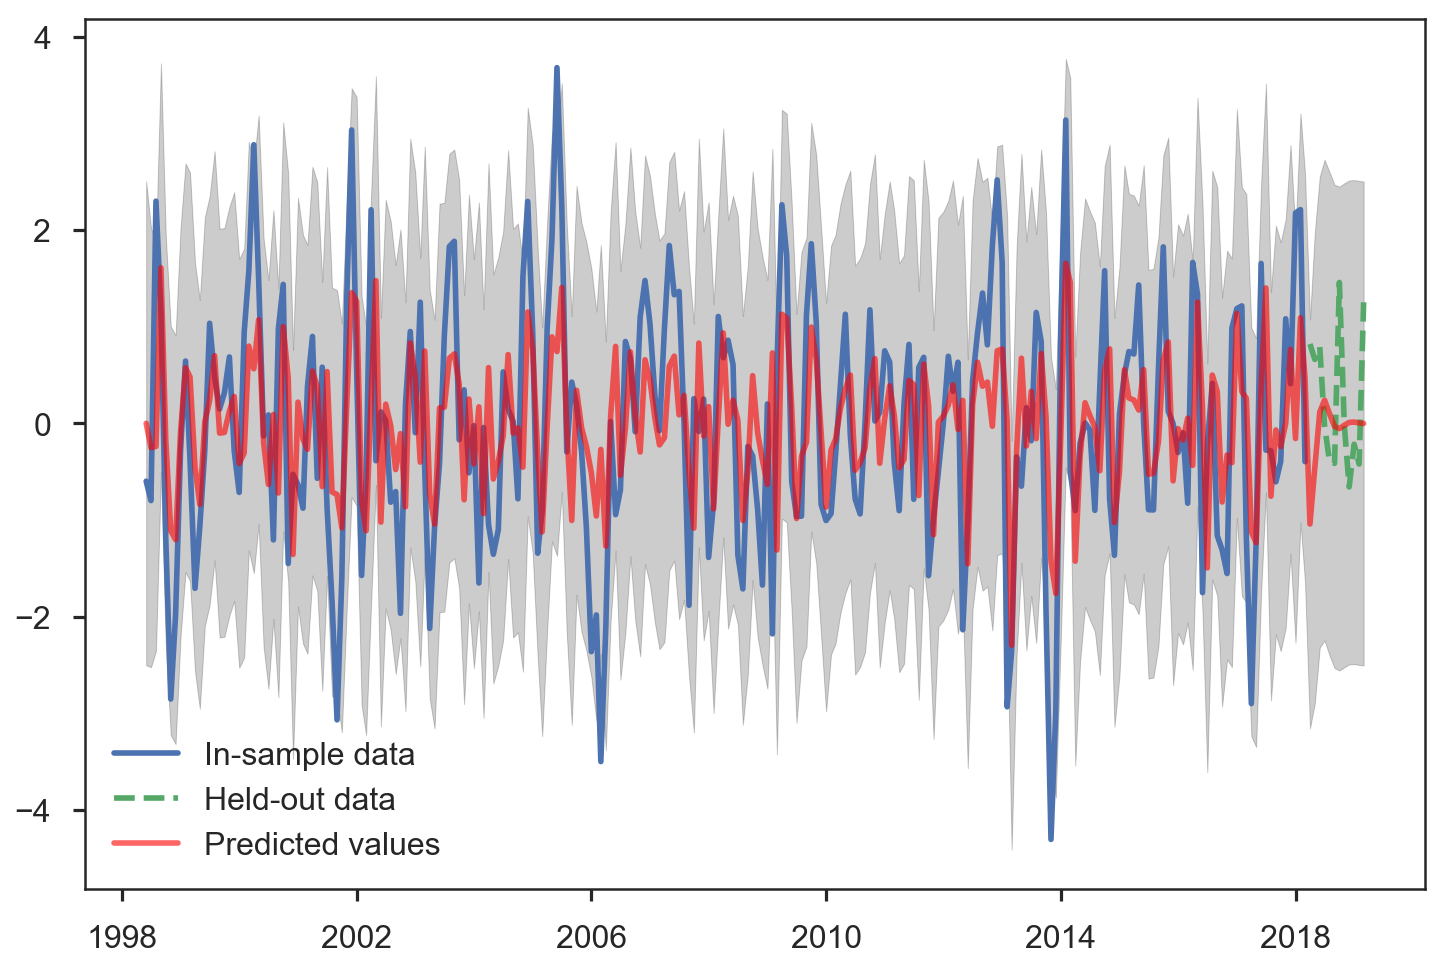

In [50]:
# Step 5: Do a 5-step ahead forecast

# ... codes need to be adjusted

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(series2_train, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(series2_test, label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = series2_train.index[ex3_arima_fit.loglikelihood_burn]
pred_end = series2_test.index[-1]
pred = ex3_arima_fit.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                    end=pred_end.strftime('%Y-%m-%d'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax1.legend(loc='best');

## Discuss the results.  How does your forecast look?